In [2]:
# CELL 1: SETUP AND IMPORTS FOR DBSCAN
print("="*60)
print("STEP 1: SETUP AND IMPORTS FOR DBSCAN MODEL")
print("="*60)

# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import json
import joblib
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
%matplotlib inline

# Set style
try:
    sns.set_style("darkgrid")
    sns.set_palette("husl")
    print("✓ Using seaborn darkgrid style")
except:
    plt.style.use('default')
    print("✓ Using default matplotlib style")

# Create project directories
project_dirs = [
    'data/raw',
    'data/processed',
    'data/test',
    'models/dbscan',
    'results/plots',
    'results/detections'
]

for dir_path in project_dirs:
    os.makedirs(dir_path, exist_ok=True)
    print(f"✓ Created: {dir_path}")

# Scikit-learn imports
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score,
    confusion_matrix, classification_report
)
from sklearn.neighbors import NearestNeighbors

print("\n✅ STEP 1 COMPLETE: All imports and directories created")
print(f"Working directory: {os.getcwd()}")

STEP 1: SETUP AND IMPORTS FOR DBSCAN MODEL
✓ Using seaborn darkgrid style
✓ Created: data/raw
✓ Created: data/processed
✓ Created: data/test
✓ Created: models/dbscan
✓ Created: results/plots
✓ Created: results/detections

✅ STEP 1 COMPLETE: All imports and directories created
Working directory: c:\Users\xxalv\OneDrive\Desktop\security\DBSCAN


In [3]:
# CELL 2: LOAD IOT ATTACK DATA
print("\n" + "="*60)
print("STEP 2: LOADING IOT ATTACK DATA")
print("="*60)

# Check what files are available
print("Looking for IoT attack data files in 'data/raw/'...")
data_files = glob.glob('data/raw/*.csv')
print(f"Found {len(data_files)} CSV files")

if len(data_files) == 0:
    print("⚠️ No CSV files found! Please upload attack data to 'data/raw/'")
    raise FileNotFoundError("No CSV files found in data/raw/")
else:
    # Load all CSV files
    data_frames = []
    for file in data_files:
        print(f"\nLoading {os.path.basename(file)}...")
        try:
            df = pd.read_csv(file)
            print(f"  Shape: {df.shape}")
            data_frames.append(df)
            print(f"  ✓ Loaded {len(df)} records")
        except Exception as e:
            print(f"  ✗ Error loading {file}: {e}")
    
    if data_frames:
        attack_data = pd.concat(data_frames, ignore_index=True)
        print(f"\n✅ Total attack samples loaded: {len(attack_data)}")
    else:
        raise ValueError("No valid CSV files could be loaded")

print("\n📊 DATA OVERVIEW:")
print(f"Shape: {attack_data.shape}")
print(f"\nFirst 3 rows:")
print(attack_data.head(3))
print(f"\nMissing values per column:")
missing = attack_data.isnull().sum()
print(missing[missing > 0])

print("\n✅ STEP 2 COMPLETE: IoT attack data loaded successfully")


STEP 2: LOADING IOT ATTACK DATA
Looking for IoT attack data files in 'data/raw/'...
Found 1 CSV files

Loading DDoS-ACK_Fragmentation.pcap.csv...
  Shape: (25090, 39)
  ✓ Loaded 25090 records

✅ Total attack samples loaded: 25090

📊 DATA OVERVIEW:
Shape: (25090, 39)

First 3 rows:
   Header_Length  Protocol Type  Time_To_Live         Rate  fin_flag_number  \
0          12.40              6         67.58  1622.429212              0.0   
1          16.00              6         65.67  2784.359856              0.0   
2          13.48              6         63.82  7138.268831              0.0   

   syn_flag_number  rst_flag_number  psh_flag_number  ack_flag_number  \
0             0.01             0.19              0.0             0.42   
1             0.01             0.60              0.0             0.19   
2             0.00             0.35              0.0             0.32   

   ece_flag_number  ...  LLC  Tot sum  Min   Max     AVG         Std  \
0              0.0  ...  1.0    764

In [4]:
# CELL 3: CREATE SYNTHETIC NORMAL DATA
print("\n" + "="*60)
print("STEP 3: CREATING SYNTHETIC NORMAL DATA")
print("="*60)

def create_synthetic_normal_for_iot(df, n_samples=1000):
    """Create synthetic normal-like data for IoT features"""
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"  Found {len(numeric_cols)} numeric columns")
    
    synthetic_data = []
    
    for _ in range(n_samples):
        sample = {}
        
        for col in numeric_cols:
            col_data = df[col]
            clean_data = col_data.replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(clean_data) > 0:
                median_val = clean_data.median()
                std_val = clean_data.std()
                
                if std_val > 0:
                    low_percentile = clean_data.quantile(0.3)
                    value = np.random.normal(low_percentile, std_val * 0.1)
                else:
                    value = median_val
                
                # Apply column-specific bounds
                if 'count' in col.lower() or 'number' in col.lower():
                    value = max(0, min(value, 100))
                elif 'rate' in col.lower():
                    value = max(0, min(value, 100))
                elif 'length' in col.lower() or 'size' in col.lower():
                    value = max(1, min(value, 1500))
                elif 'time' in col.lower() or 'iat' in col.lower():
                    value = max(0.001, min(value, 10))
                elif col in ['Min', 'Max', 'AVG', 'Std', 'Variance']:
                    value = abs(value)
                elif any(proto in col.lower() for proto in ['http', 'https', 'dns', 'ssh', 'tcp', 'udp']):
                    value = 1 if np.random.random() < 0.1 else 0
                
                sample[col] = value
            else:
                sample[col] = 0
        
        synthetic_data.append(sample)
    
    synthetic_df = pd.DataFrame(synthetic_data)
    
    # Ensure we have all columns
    missing_cols = set(df.columns) - set(synthetic_df.columns)
    for col in missing_cols:
        synthetic_df[col] = df[col].iloc[0] if len(df) > 0 else 0
    
    return synthetic_df

# Create synthetic normal data
synthetic_normal = create_synthetic_normal_for_iot(attack_data, n_samples=500)
print(f"✅ Created {len(synthetic_normal)} synthetic normal samples")
print(f"Synthetic data shape: {synthetic_normal.shape}")

print("\n📊 STATISTICS COMPARISON:")
print("="*40)
print("ATTACK DATA:")
print(f"  Samples: {len(attack_data)}")
print(f"  Avg Rate: {attack_data['Rate'].mean():.2f}" if 'Rate' in attack_data.columns else "")

print("\nSYNTHETIC NORMAL DATA:")
print(f"  Samples: {len(synthetic_normal)}")
print(f"  Avg Rate: {synthetic_normal['Rate'].mean():.2f}" if 'Rate' in synthetic_normal.columns else "")

print("\n✅ STEP 3 COMPLETE: Synthetic normal data created")


STEP 3: CREATING SYNTHETIC NORMAL DATA
  Found 39 numeric columns
✅ Created 500 synthetic normal samples
Synthetic data shape: (500, 39)

📊 STATISTICS COMPARISON:
ATTACK DATA:
  Samples: 25090
  Avg Rate: inf

SYNTHETIC NORMAL DATA:
  Samples: 500
  Avg Rate: 78.73

✅ STEP 3 COMPLETE: Synthetic normal data created


In [5]:
# CELL 4: PREPROCESS DATA
print("\n" + "="*60)
print("STEP 4: PREPROCESSING DATA")
print("="*60)

def preprocess_iot_data(df):
    """Preprocess IoT dataset"""
    df_processed = df.copy()
    print(f"  Original shape: {df_processed.shape}")
    
    # 1. Handle missing values
    for col in df_processed.columns:
        if df_processed[col].isnull().sum() > 0:
            if pd.api.types.is_numeric_dtype(df_processed[col]):
                if any(x in col.lower() for x in ['count', 'number', 'rate', 'flag']):
                    df_processed[col] = df_processed[col].fillna(0)
                else:
                    median_val = df_processed[col].median()
                    df_processed[col] = df_processed[col].fillna(median_val)
            else:
                df_processed[col] = df_processed[col].fillna('unknown')
    
    # 2. Handle infinite values
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_processed[col].dtype in [np.float64, np.float32]:
            inf_count = np.isinf(df_processed[col]).sum()
            if inf_count > 0:
                col_max = df_processed[col][~np.isinf(df_processed[col])].max()
                col_min = df_processed[col][~np.isinf(df_processed[col])].min()
                if not np.isnan(col_max) and not np.isnan(col_min):
                    df_processed[col] = df_processed[col].replace(np.inf, col_max * 2)
                    df_processed[col] = df_processed[col].replace(-np.inf, col_min * 2)
                else:
                    df_processed[col] = df_processed[col].replace([np.inf, -np.inf], 0)
    
    # 3. Remove duplicates
    initial_len = len(df_processed)
    df_processed = df_processed.drop_duplicates()
    if len(df_processed) < initial_len:
        print(f"  Removed {initial_len - len(df_processed)} duplicates")
    
    # 4. Handle extreme values
    iot_bounds = {
        'Header_Length': (0, 65535), 'Time_To_Live': (0, 255), 'Rate': (0, 10000),
        'fin_flag_number': (0, 1000), 'syn_flag_number': (0, 10000), 'rst_flag_number': (0, 1000),
        'psh_flag_number': (0, 1000), 'ack_flag_number': (0, 10000), 'ece_flag_number': (0, 100),
        'cwr_flag_number': (0, 100), 'ack_count': (0, 10000), 'syn_count': (0, 10000),
        'fin_count': (0, 1000), 'rst_count': (0, 1000), 'HTTP': (0, 1), 'HTTPS': (0, 1),
        'DNS': (0, 1), 'Telnet': (0, 1), 'SMTP': (0, 1), 'SSH': (0, 1), 'IRC': (0, 1),
        'TCP': (0, 1), 'UDP': (0, 1), 'DHCP': (0, 1), 'ARP': (0, 1), 'ICMP': (0, 1),
        'IGMP': (0, 1), 'IPv': (0, 1), 'LLC': (0, 1), 'Tot_sum': (0, 1e9), 'Min': (0, 10000),
        'Max': (0, 10000), 'AVG': (0, 10000), 'Std': (0, 5000), 'Tot_size': (0, 1e9),
        'IAT': (0, 100), 'Number': (0, 10000), 'Variance': (0, 1e6)
    }
    
    for col in numeric_cols:
        col_lower = col.lower()
        for bound_key, (min_val, max_val) in iot_bounds.items():
            if bound_key.lower() in col_lower:
                outliers = (df_processed[col] > max_val).sum() + (df_processed[col] < min_val).sum()
                if outliers > 0:
                    df_processed[col] = df_processed[col].clip(min_val, max_val)
                break
    
    # 5. Encode categorical variables
    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
    for col in categorical_cols:
        unique_count = df_processed[col].nunique()
        if unique_count < 50:
            df_processed[col] = pd.factorize(df_processed[col])[0]
        else:
            df_processed = df_processed.drop(col, axis=1)
    
    numerical_features = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    print(f"  Final shape: {df_processed.shape}")
    print(f"  Using {len(numerical_features)} numerical features")
    
    return df_processed, numerical_features

# Preprocess attack data
print("Preprocessing attack data...")
attack_processed, features = preprocess_iot_data(attack_data)

# Preprocess synthetic normal data
print("\nPreprocessing synthetic normal data...")
normal_processed, _ = preprocess_iot_data(synthetic_normal)

print("\n✅ STEP 4 COMPLETE: Data preprocessing done")


STEP 4: PREPROCESSING DATA
Preprocessing attack data...
  Original shape: (25090, 39)
  Removed 4 duplicates
  Final shape: (25086, 39)
  Using 39 numerical features

Preprocessing synthetic normal data...
  Original shape: (500, 39)
  Final shape: (500, 39)
  Using 39 numerical features

✅ STEP 4 COMPLETE: Data preprocessing done


In [6]:
# CELL 5: FEATURE ENGINEERING FOR DBSCAN
print("\n" + "="*60)
print("STEP 5: FEATURE ENGINEERING FOR DBSCAN CLUSTERING")
print("="*60)

def engineer_iot_features(df, features_list):
    """Create specialized features for IoT attack detection"""
    print(f"  Starting with {len(features_list)} base features")
    
    df_features = df[features_list].copy()
    
    # 1. Flag ratio features
    flag_cols = ['fin_flag_number', 'syn_flag_number', 'rst_flag_number', 
                 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number']
    available_flags = [col for col in flag_cols if col in df.columns]
    
    if len(available_flags) >= 2:
        df_features['total_flags'] = df[available_flags].sum(axis=1)
        if 'syn_flag_number' in available_flags:
            df_features['syn_to_total_ratio'] = np.where(
                df_features['total_flags'] > 0,
                df['syn_flag_number'] / df_features['total_flags'],
                0
            )
        if 'ack_flag_number' in available_flags:
            df_features['ack_to_total_ratio'] = np.where(
                df_features['total_flags'] > 0,
                df['ack_flag_number'] / df_features['total_flags'],
                0
            )
    
    # 2. Protocol interaction features
    protocol_cols = ['HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 
                    'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 'IPv', 'LLC']
    available_protocols = [col for col in protocol_cols if col in df.columns]
    
    if len(available_protocols) >= 2:
        df_features['active_protocols'] = df[available_protocols].sum(axis=1)
        if all(col in df.columns for col in ['TCP', 'UDP']):
            df_features['tcp_udp_both'] = ((df['TCP'] > 0) & (df['UDP'] > 0)).astype(int)
        if all(col in df.columns for col in ['ICMP', 'Rate']):
            df_features['icmp_flood_suspicion'] = ((df['ICMP'] > 0) & (df['Rate'] > 1000)).astype(int)
    
    # 3. Statistical anomaly features
    if all(col in df.columns for col in ['Std', 'AVG']):
        df_features['coeff_variation'] = np.where(
            df['AVG'] > 0,
            df['Std'] / df['AVG'],
            0
        )
        df_features['high_variance'] = (df['Std'] > 3 * df['AVG']).astype(int)
    
    if all(col in df.columns for col in ['Max', 'Min']):
        df_features['value_range'] = df['Max'] - df['Min']
    
    # 4. Rate-based features
    if 'Rate' in df.columns:
        df_features['rate_category'] = pd.cut(df['Rate'], 
                                              bins=[-1, 10, 100, 1000, 10000, float('inf')],
                                              labels=['very_low', 'low', 'medium', 'high', 'very_high'])
        df_features['rate_category'] = pd.factorize(df_features['rate_category'])[0]
        rate_q75 = df['Rate'].quantile(0.75)
        rate_q25 = df['Rate'].quantile(0.25)
        iqr = rate_q75 - rate_q25
        upper_bound = rate_q75 + 1.5 * iqr
        df_features['rate_outlier'] = (df['Rate'] > upper_bound).astype(int)
    
    # 5. Time-based features
    if 'IAT' in df.columns:
        df_features['log_iat'] = np.log1p(df['IAT'])
        df_features['iat_reciprocal'] = np.where(df['IAT'] > 0, 1 / df['IAT'], 0)
        iat_threshold = df['IAT'].quantile(0.1)
        df_features['low_iat_burst'] = (df['IAT'] < iat_threshold).astype(int)
    
    # 6. Composite attack indicators
    if all(col in df.columns for col in ['syn_flag_number', 'Rate']):
        syn_threshold = df['syn_flag_number'].quantile(0.9)
        rate_threshold = df['Rate'].quantile(0.9)
        df_features['syn_flood_indicator'] = (
            (df['syn_flag_number'] > syn_threshold) & 
            (df['Rate'] > rate_threshold)
        ).astype(int)
    
    if 'Rate' in df.columns and 'active_protocols' in df_features.columns:
        rate_threshold = df['Rate'].quantile(0.9)
        protocol_threshold = df_features['active_protocols'].quantile(0.9)
        df_features['ddos_indicator'] = (
            (df['Rate'] > rate_threshold) & 
            (df_features['active_protocols'] > protocol_threshold)
        ).astype(int)
    
    if 'active_protocols' in df_features.columns:
        scan_threshold = df_features['active_protocols'].quantile(0.95)
        df_features['port_scan_indicator'] = (
            df_features['active_protocols'] > scan_threshold
        ).astype(int)
    
    # Fill NaN and infinite values
    df_features = df_features.fillna(0)
    for col in df_features.columns:
        if pd.api.types.is_numeric_dtype(df_features[col]):
            df_features[col] = df_features[col].replace([np.inf, -np.inf], 0)
    
    print(f"  Final feature matrix shape: {df_features.shape}")
    print(f"  Total features created: {len(df_features.columns)}")
    
    return df_features

# Apply feature engineering
print("Engineering features for attack data...")
X_attack = engineer_iot_features(attack_processed, features)
print(f"✅ Attack features shape: {X_attack.shape}")

print("\nEngineering features for synthetic normal data...")
X_normal = engineer_iot_features(normal_processed, features)
print(f"✅ Normal features shape: {X_normal.shape}")

# Save feature information
print("\n💾 Saving feature information...")
all_features = list(X_attack.columns)
joblib.dump(all_features, 'models/dbscan/all_features.pkl')

print(f"\n📊 ENGINEERED FEATURES SUMMARY:")
print(f"Total features: {len(all_features)}")
print(f"Base features: {len(features)}")
print(f"Engineered features: {len(all_features) - len(features)}")

print("\n✅ STEP 5 COMPLETE: Feature engineering done")


STEP 5: FEATURE ENGINEERING FOR DBSCAN CLUSTERING
Engineering features for attack data...
  Starting with 39 base features
  Final feature matrix shape: (25086, 56)
  Total features created: 56
✅ Attack features shape: (25086, 56)

Engineering features for synthetic normal data...
  Starting with 39 base features
  Final feature matrix shape: (500, 56)
  Total features created: 56
✅ Normal features shape: (500, 56)

💾 Saving feature information...

📊 ENGINEERED FEATURES SUMMARY:
Total features: 56
Base features: 39
Engineered features: 17

✅ STEP 5 COMPLETE: Feature engineering done


In [7]:
# CELL 6: SCALE FEATURES FOR DBSCAN
print("\n" + "="*60)
print("STEP 6: SCALING FEATURES FOR DBSCAN")
print("="*60)

# DBSCAN is distance-based, so scaling is CRITICAL
scaler = StandardScaler()

# Clean data
X_attack_clean = X_attack.fillna(0).replace([np.inf, -np.inf], 0)
X_normal_clean = X_normal.fillna(0).replace([np.inf, -np.inf], 0)

X_attack_array = X_attack_clean.values
X_normal_array = X_normal_clean.values

print(f"Attack array shape: {X_attack_array.shape}")
print(f"Normal array shape: {X_normal_array.shape}")

# Combine for scaling
X_combined = np.vstack([X_attack_array, X_normal_array])

# Fit scaler on combined data
print("\nFitting StandardScaler on combined data...")
X_combined_scaled = scaler.fit_transform(X_combined)
print(f"✅ Combined data scaled: {X_combined_scaled.shape}")

# Split back
X_attack_scaled = X_combined_scaled[:len(X_attack_array)]
X_normal_scaled = X_combined_scaled[len(X_attack_array):]

print(f"Attack data scaled: {X_attack_scaled.shape}")
print(f"Normal data scaled: {X_normal_scaled.shape}")

# Save the scaler
scaler_path = 'models/dbscan/iot_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved to '{scaler_path}'")

# Save feature names
feature_names_path = 'models/dbscan/iot_feature_names.pkl'
joblib.dump(list(X_attack.columns), feature_names_path)
print(f"✅ Feature names saved to '{feature_names_path}'")

print("\n✅ STEP 6 COMPLETE: Features scaled successfully")


STEP 6: SCALING FEATURES FOR DBSCAN
Attack array shape: (25086, 56)
Normal array shape: (500, 56)

Fitting StandardScaler on combined data...
✅ Combined data scaled: (25586, 56)
Attack data scaled: (25086, 56)
Normal data scaled: (500, 56)
✅ Scaler saved to 'models/dbscan/iot_scaler.pkl'
✅ Feature names saved to 'models/dbscan/iot_feature_names.pkl'

✅ STEP 6 COMPLETE: Features scaled successfully



STEP 7: FINDING OPTIMAL DBSCAN PARAMETERS
Analyzing attack data for DBSCAN parameters...
  Finding optimal epsilon for min_samples=10...
  Suggested epsilon: 170.7344
  Elbow point at index: 25085

Analyzing combined data for DBSCAN parameters...
  Finding optimal epsilon for min_samples=10...
  Suggested epsilon: 170.7344
  Elbow point at index: 25585

📊 RECOMMENDED DBSCAN PARAMETERS:
  For attack data: eps=170.7344, min_samples=10
  For combined data: eps=170.7344, min_samples=10


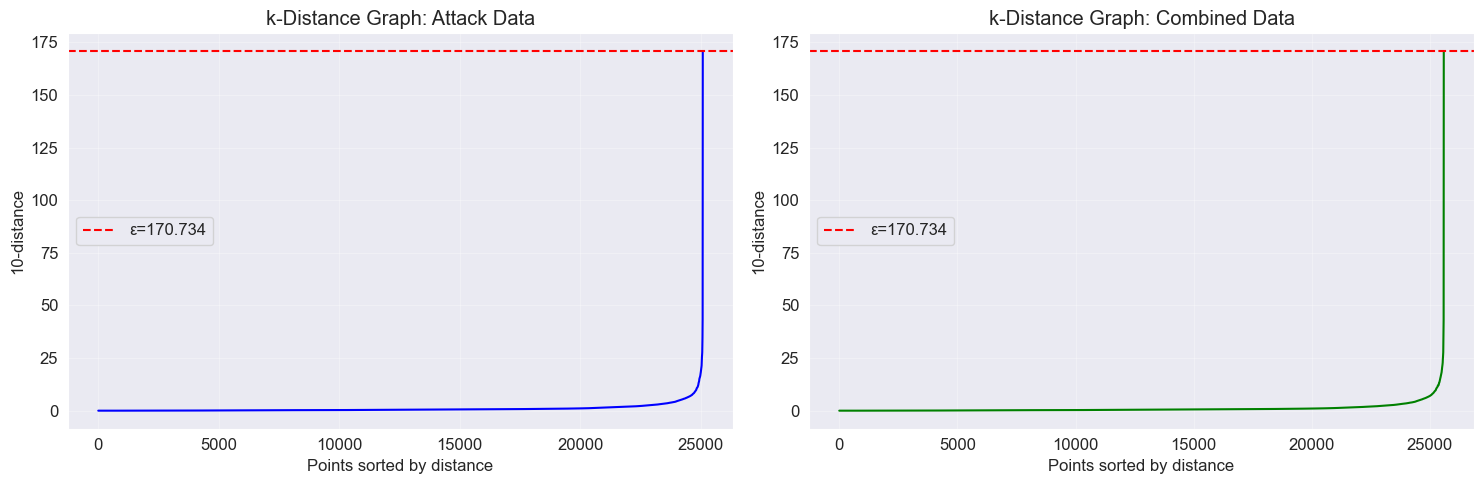


✅ STEP 7 COMPLETE: Optimal parameters found


In [8]:
# CELL 7: FIND OPTIMAL DBSCAN PARAMETERS
print("\n" + "="*60)
print("STEP 7: FINDING OPTIMAL DBSCAN PARAMETERS")
print("="*60)

def find_optimal_epsilon(X, min_samples=5, k=4):
    """Find optimal epsilon using k-distance graph"""
    print(f"  Finding optimal epsilon for min_samples={min_samples}...")
    
    # Fit k-nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=min_samples).fit(X)
    
    # Find k-distances
    distances, indices = nbrs.kneighbors(X)
    
    # Sort k-distances
    k_distances = distances[:, -1]
    k_distances_sorted = np.sort(k_distances)
    
    # Find elbow point
    diff = np.diff(k_distances_sorted)
    diff2 = np.diff(diff)
    elbow_idx = np.argmax(diff2) + 2 if len(diff2) > 0 else len(k_distances_sorted) // 10
    
    optimal_epsilon = k_distances_sorted[elbow_idx]
    
    print(f"  Suggested epsilon: {optimal_epsilon:.4f}")
    print(f"  Elbow point at index: {elbow_idx}")
    
    return optimal_epsilon, k_distances_sorted

# Find optimal epsilon for attack data
print("Analyzing attack data for DBSCAN parameters...")
epsilon_attack, k_distances_attack = find_optimal_epsilon(X_attack_scaled, min_samples=10)

# Find optimal epsilon for combined data
print("\nAnalyzing combined data for DBSCAN parameters...")
epsilon_combined, k_distances_combined = find_optimal_epsilon(X_combined_scaled, min_samples=10)

print(f"\n📊 RECOMMENDED DBSCAN PARAMETERS:")
print(f"  For attack data: eps={epsilon_attack:.4f}, min_samples=10")
print(f"  For combined data: eps={epsilon_combined:.4f}, min_samples=10")

# Visualize k-distance graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Attack data k-distance
ax1.plot(k_distances_attack, 'b-')
ax1.axhline(y=epsilon_attack, color='r', linestyle='--', label=f'ε={epsilon_attack:.3f}')
ax1.set_xlabel('Points sorted by distance')
ax1.set_ylabel(f'10-distance')
ax1.set_title('k-Distance Graph: Attack Data')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Combined data k-distance
ax2.plot(k_distances_combined, 'g-')
ax2.axhline(y=epsilon_combined, color='r', linestyle='--', label=f'ε={epsilon_combined:.3f}')
ax2.set_xlabel('Points sorted by distance')
ax2.set_ylabel(f'10-distance')
ax2.set_title('k-Distance Graph: Combined Data')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/plots/dbscan_epsilon_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ STEP 7 COMPLETE: Optimal parameters found")

In [9]:
# CELL 8: LIGHTWEIGHT DBSCAN TRAINING
print("\n" + "="*60)
print("STEP 8: LIGHTWEIGHT DBSCAN TRAINING")
print("="*60)

print("Using lightweight configuration for laptop...")

# 1. Use only attack data (ignore normal for now)
print("Using only attack data for training...")
X_train = X_attack_scaled

# 2. Use much smaller subset
sample_size = min(3000, len(X_train))
np.random.seed(42)
indices = np.random.choice(len(X_train), size=sample_size, replace=False)
X_small = X_train[indices]

print(f"Training on {sample_size:,} samples (reduced from {len(X_train):,})")

# 3. Use optimized parameters
dbscan_light = DBSCAN(
    eps=0.5,  # Fixed, reasonable epsilon
    min_samples=5,  # Reduced from 10
    metric='euclidean',
    algorithm='ball_tree',  # Memory efficient
    leaf_size=50,
    n_jobs=1,  # Single core only
    p=None
)

print("\nTraining DBSCAN...")
labels_light = dbscan_light.fit_predict(X_small)

n_clusters = len(set(labels_light)) - (1 if -1 in labels_light else 0)
n_noise = list(labels_light).count(-1)

print(f"✅ DBSCAN Results (Lightweight):")
print(f"  Clusters found: {n_clusters}")
print(f"  Noise points: {n_noise} ({n_noise/len(labels_light):.1%})")

# Save model
model_path = 'models/dbscan/dbscan_light.pkl'
joblib.dump(dbscan_light, model_path)
print(f"💾 Model saved: {model_path}")

print("\n⚠️ Note: This is a lightweight model.")
print("For production, use more data or cloud computing.")

print("\n✅ STEP 8 COMPLETE: Lightweight DBSCAN trained")


STEP 8: LIGHTWEIGHT DBSCAN TRAINING
Using lightweight configuration for laptop...
Using only attack data for training...
Training on 3,000 samples (reduced from 25,086)

Training DBSCAN...


✅ DBSCAN Results (Lightweight):
  Clusters found: 51
  Noise points: 1497 (49.9%)
💾 Model saved: models/dbscan/dbscan_light.pkl

⚠️ Note: This is a lightweight model.
For production, use more data or cloud computing.

✅ STEP 8 COMPLETE: Lightweight DBSCAN trained


In [10]:
# CELL 9: EVALUATE LIGHTWEIGHT DBSCAN MODEL
print("\n" + "="*60)
print("STEP 9: EVALUATING LIGHTWEIGHT DBSCAN MODEL")
print("="*60)

print("Evaluating model performance...")

# Load the lightweight model
dbscan_light = joblib.load('models/dbscan/dbscan_light.pkl')

# Use a separate test set for evaluation
print("Creating test set for evaluation...")
test_size = min(1000, len(X_attack_scaled) // 5)
np.random.seed(42)
test_indices = np.random.choice(len(X_attack_scaled), size=test_size, replace=False)
train_indices = np.setdiff1d(np.arange(len(X_attack_scaled)), test_indices)

X_test = X_attack_scaled[test_indices]
X_train_eval = X_attack_scaled[train_indices[:3000]]  # Use 3000 for training

print(f"  Training samples: {len(X_train_eval):,}")
print(f"  Test samples: {len(X_test):,}")

# Train on training set
print("\nTraining DBSCAN on evaluation training set...")
dbscan_eval = DBSCAN(
    eps=0.5,
    min_samples=5,
    metric='euclidean',
    algorithm='ball_tree',
    leaf_size=50,
    n_jobs=1
)

train_labels = dbscan_eval.fit_predict(X_train_eval)

# Predict on test set using approximate method
print("Predicting on test set...")
test_labels = np.zeros(len(X_test), dtype=int) - 2  # Initialize with unique value

# Simple prediction: find nearest training point and use its label
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X_train_eval)
distances, indices = nbrs.kneighbors(X_test)

# Assign label of nearest neighbor
for i in range(len(X_test)):
    nearest_idx = indices[i][0]
    test_labels[i] = train_labels[nearest_idx]

# Mark as noise if distance is too large
noise_mask = distances.flatten() > 0.5  # If too far from any training point
test_labels[noise_mask] = -1

# Evaluate
n_clusters_test = len(set(test_labels)) - (1 if -1 in test_labels else 0)
n_noise_test = list(test_labels).count(-1)

print(f"\n📊 EVALUATION RESULTS ON TEST SET:")
print(f"  Test samples: {len(X_test):,}")
print(f"  Clusters identified: {n_clusters_test}")
print(f"  Noise points: {n_noise_test} ({n_noise_test/len(X_test):.1%})")

# Calculate silhouette score (if we have more than 1 cluster)
if n_clusters_test > 1 and len(set(test_labels[test_labels != -1])) > 1:
    # Only use non-noise points for silhouette
    non_noise_mask = test_labels != -1
    if np.sum(non_noise_mask) > 1:
        try:
            from sklearn.metrics import silhouette_score
            silhouette = silhouette_score(X_test[non_noise_mask], test_labels[non_noise_mask])
            print(f"  Silhouette Score: {silhouette:.3f}")
            print(f"    • >0.7: Strong structure")
            print(f"    • 0.5-0.7: Reasonable structure")
            print(f"    • 0.25-0.5: Weak structure")
            print(f"    • <0.25: No substantial structure")
        except:
            print("  Silhouette Score: Could not compute")

# Save evaluation metrics
metrics = {
    'test_samples': int(len(X_test)),
    'clusters_identified': int(n_clusters_test),
    'noise_points': int(n_noise_test),
    'noise_percentage': float(n_noise_test/len(X_test)),
    'model_parameters': {
        'eps': 0.5,
        'min_samples': 5,
        'algorithm': 'ball_tree'
    }
}

# Add silhouette if computed
if 'silhouette' in locals():
    metrics['silhouette_score'] = float(silhouette)

metrics_path = 'models/dbscan/dbscan_evaluation_metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

print(f"\n💾 Evaluation metrics saved to: {metrics_path}")
print("\n✅ STEP 9 COMPLETE: Model evaluated")


STEP 9: EVALUATING LIGHTWEIGHT DBSCAN MODEL
Evaluating model performance...
Creating test set for evaluation...
  Training samples: 3,000
  Test samples: 1,000

Training DBSCAN on evaluation training set...
Predicting on test set...

📊 EVALUATION RESULTS ON TEST SET:
  Test samples: 1,000
  Clusters identified: 42
  Noise points: 542 (54.2%)
  Silhouette Score: 0.423
    • >0.7: Strong structure
    • 0.5-0.7: Reasonable structure
    • 0.25-0.5: Weak structure
    • <0.25: No substantial structure

💾 Evaluation metrics saved to: models/dbscan/dbscan_evaluation_metrics.json

✅ STEP 9 COMPLETE: Model evaluated



STEP 10: VISUALIZING DBSCAN RESULTS
Generating visualizations for lightweight DBSCAN...
Using 2,000 samples for visualization
Making predictions for visualization...
  Clusters found: 38
  Noise points: 1144 (57.2%)
Creating PCA visualization...
Creating cluster size distribution...
Analyzing feature importance...
Analyzing rate by cluster...
Analyzing TCP flags...
Creating noise analysis...

✅ Visualization saved to: results/plots/dbscan_lightweight_analysis.png


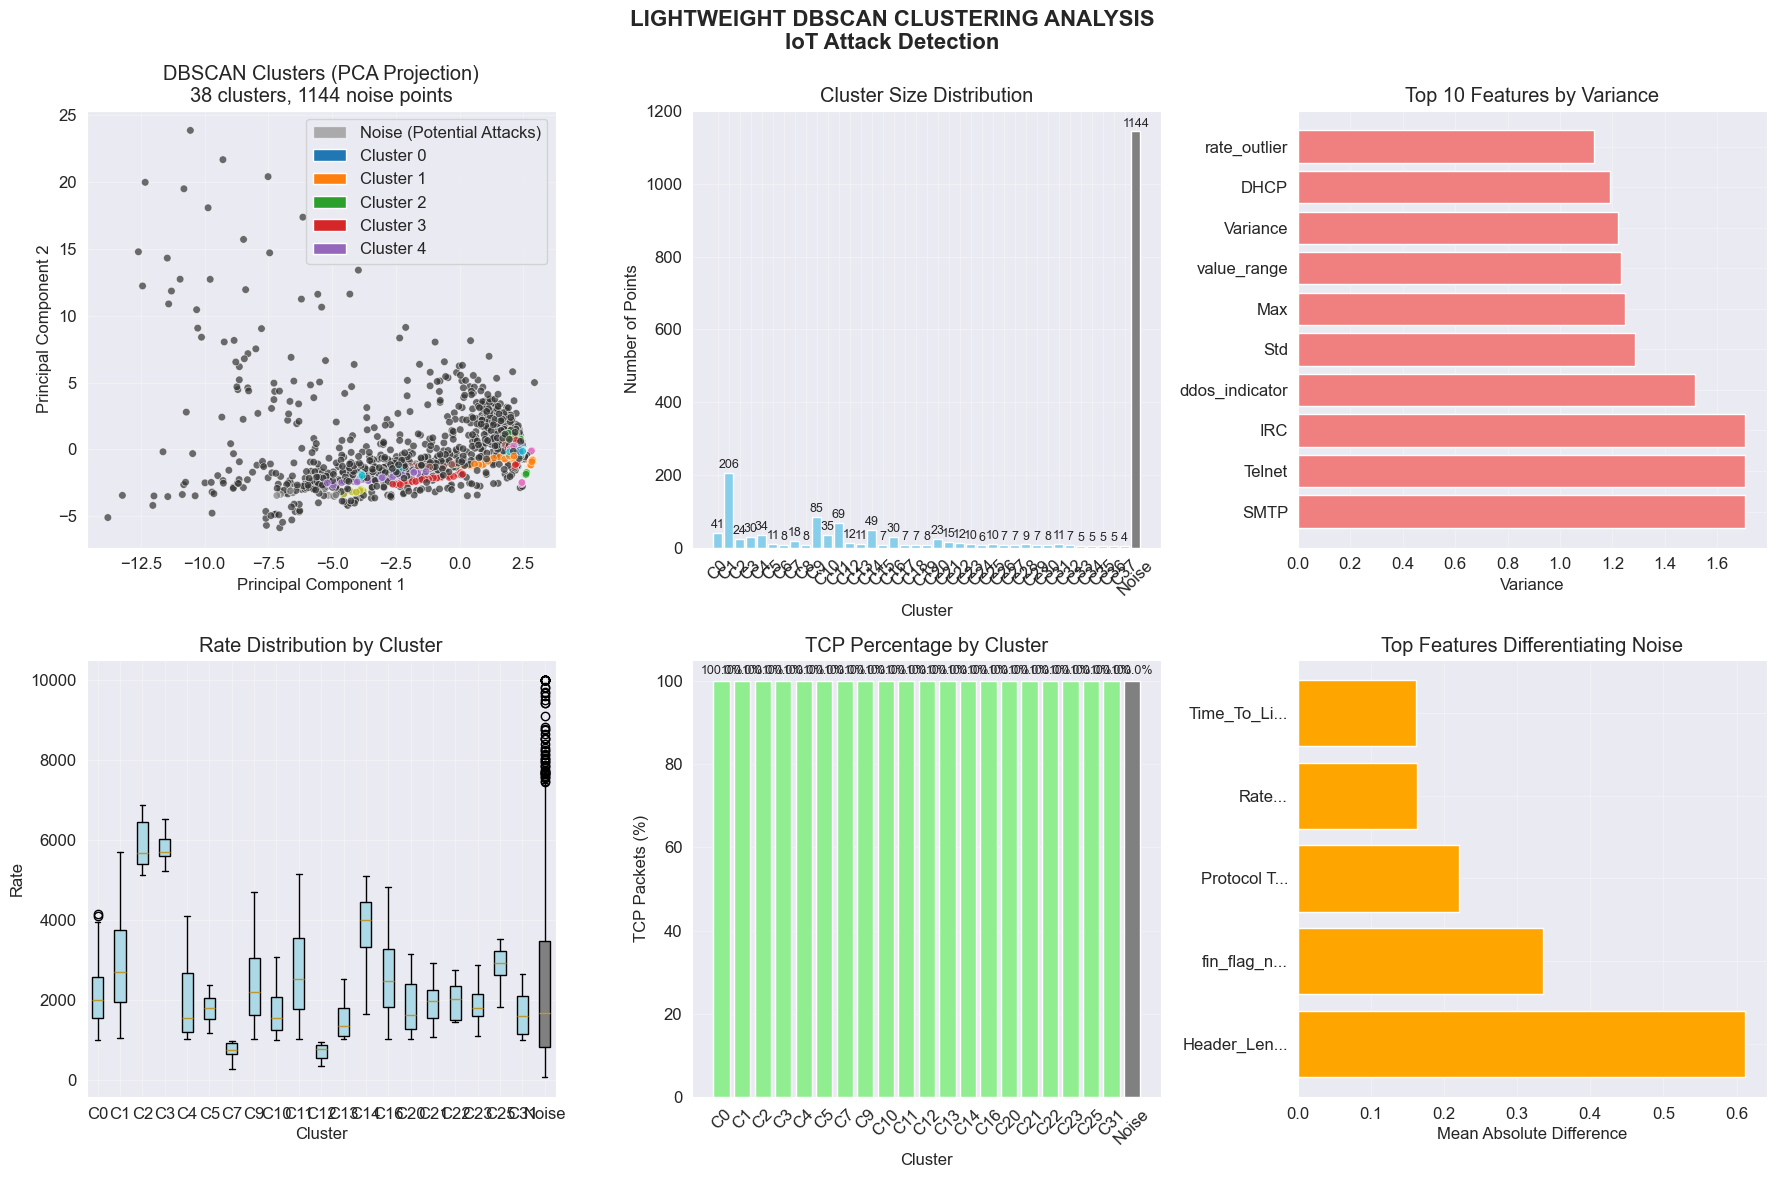


✅ STEP 10 COMPLETE: Visualizations generated


In [11]:
# CELL 10: VISUALIZE DBSCAN RESULTS
print("\n" + "="*60)
print("STEP 10: VISUALIZING DBSCAN RESULTS")
print("="*60)

print("Generating visualizations for lightweight DBSCAN...")

# Load model and data
dbscan_light = joblib.load('models/dbscan/dbscan_light.pkl')
scaler = joblib.load('models/dbscan/iot_scaler.pkl')
feature_names = joblib.load('models/dbscan/iot_feature_names.pkl')

# Use subset for visualization (faster)
viz_size = min(2000, len(X_attack_scaled))
np.random.seed(42)
viz_indices = np.random.choice(len(X_attack_scaled), size=viz_size, replace=False)
X_viz = X_attack_scaled[viz_indices]

print(f"Using {viz_size:,} samples for visualization")

# Get predictions
print("Making predictions for visualization...")
viz_labels = dbscan_light.fit_predict(X_viz)

# Count clusters and noise
unique_labels = set(viz_labels)
n_clusters_viz = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise_viz = list(viz_labels).count(-1)

print(f"  Clusters found: {n_clusters_viz}")
print(f"  Noise points: {n_noise_viz} ({n_noise_viz/viz_size:.1%})")

# Create visualization figure
fig = plt.figure(figsize=(18, 12))

# 1. PCA Projection with Clusters
ax1 = plt.subplot(2, 3, 1)
print("Creating PCA visualization...")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_viz)

# Create color map
colors = []
for label in viz_labels:
    if label == -1:
        colors.append([0.2, 0.2, 0.2, 0.6])  # Gray for noise
    else:
        # Use colormap for clusters
        color_val = (label % 10) / 10  # Cycle through colors
        colors.append(plt.cm.tab20(color_val))

scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=colors, s=30, alpha=0.7, edgecolors='w', linewidth=0.5)

# Add legend for noise
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='gray', alpha=0.6, label='Noise (Potential Attacks)')]
for i in range(min(5, n_clusters_viz)):  # Show up to 5 clusters
    legend_elements.append(Patch(facecolor=plt.cm.tab20(i/10), 
                                label=f'Cluster {i}'))

ax1.legend(handles=legend_elements, loc='upper right')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_title(f'DBSCAN Clusters (PCA Projection)\n{n_clusters_viz} clusters, {n_noise_viz} noise points')
ax1.grid(True, alpha=0.3)

# 2. Cluster Size Distribution
ax2 = plt.subplot(2, 3, 2)
print("Creating cluster size distribution...")

cluster_sizes = []
cluster_labels_sorted = []

for label in sorted(unique_labels):
    if label != -1:
        size = list(viz_labels).count(label)
        cluster_sizes.append(size)
        cluster_labels_sorted.append(f'C{label}')

if cluster_sizes:
    # Add noise as separate bar
    if n_noise_viz > 0:
        cluster_sizes.append(n_noise_viz)
        cluster_labels_sorted.append('Noise')
    
    bars = ax2.bar(range(len(cluster_sizes)), cluster_sizes, 
                  color=['skyblue' if 'C' in label else 'gray' for label in cluster_labels_sorted])
    
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Number of Points')
    ax2.set_title('Cluster Size Distribution')
    ax2.set_xticks(range(len(cluster_labels_sorted)))
    ax2.set_xticklabels(cluster_labels_sorted, rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, (bar, size) in enumerate(zip(bars, cluster_sizes)):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{size}', ha='center', va='bottom', fontsize=9)
else:
    ax2.text(0.5, 0.5, 'No clusters found\n(all points are noise)',
            ha='center', va='center', transform=ax2.transAxes)
    ax2.set_title('Cluster Size Distribution')

# 3. Feature Importance for Clustering
ax3 = plt.subplot(2, 3, 3)
print("Analyzing feature importance...")

# Simple feature importance: variance in each feature
feature_variance = np.var(X_viz, axis=0)
top_n = min(10, len(feature_names))
top_indices = np.argsort(feature_variance)[-top_n:][::-1]

top_features = [feature_names[i][:15] + '...' if len(feature_names[i]) > 15 else feature_names[i] 
                for i in top_indices]
top_variances = feature_variance[top_indices]

bars = ax3.barh(range(top_n), top_variances, color='lightcoral')
ax3.set_yticks(range(top_n))
ax3.set_yticklabels(top_features)
ax3.set_xlabel('Variance')
ax3.set_title(f'Top {top_n} Features by Variance')
ax3.grid(True, alpha=0.3, axis='x')

# 4. Rate Analysis by Cluster
ax4 = plt.subplot(2, 3, 4)
print("Analyzing rate by cluster...")

# Get original attack data for the subset
attack_data_viz = attack_processed.iloc[viz_indices]

if 'Rate' in attack_data_viz.columns and n_clusters_viz > 0:
    # Prepare data for boxplot
    rate_data = []
    rate_labels = []
    
    for label in sorted(unique_labels):
        if label != -1 and list(viz_labels).count(label) >= 10:  # At least 10 points
            cluster_rates = attack_data_viz[viz_labels == label]['Rate'].values
            rate_data.append(cluster_rates)
            rate_labels.append(f'C{label}')
    
    # Add noise if enough points
    if n_noise_viz >= 10:
        noise_rates = attack_data_viz[viz_labels == -1]['Rate'].values
        rate_data.append(noise_rates)
        rate_labels.append('Noise')
    
    if rate_data:
        bp = ax4.boxplot(rate_data, labels=rate_labels, patch_artist=True)
        
        # Color boxes
        for i, (box, label) in enumerate(zip(bp['boxes'], rate_labels)):
            if label == 'Noise':
                box.set_facecolor('gray')
            else:
                box.set_facecolor('lightblue')
        
        ax4.set_xlabel('Cluster')
        ax4.set_ylabel('Rate')
        ax4.set_title('Rate Distribution by Cluster')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'Not enough data\nfor rate analysis',
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Rate Analysis')
else:
    ax4.text(0.5, 0.5, 'Rate data not available\nor no clusters found',
            ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Rate Analysis')

# 5. TCP Flag Analysis
ax5 = plt.subplot(2, 3, 5)
print("Analyzing TCP flags...")

if 'TCP' in attack_data_viz.columns and n_clusters_viz > 0:
    # Calculate TCP percentage by cluster
    tcp_percentages = []
    tcp_labels = []
    
    for label in sorted(unique_labels):
        if label != -1 and list(viz_labels).count(label) >= 10:
            cluster_tcp = attack_data_viz[viz_labels == label]['TCP'].values
            tcp_percentage = np.mean(cluster_tcp > 0) * 100
            tcp_percentages.append(tcp_percentage)
            tcp_labels.append(f'C{label}')
    
    # Add noise
    if n_noise_viz >= 10:
        noise_tcp = attack_data_viz[viz_labels == -1]['TCP'].values
        noise_tcp_percentage = np.mean(noise_tcp > 0) * 100
        tcp_percentages.append(noise_tcp_percentage)
        tcp_labels.append('Noise')
    
    if tcp_percentages:
        colors_tcp = ['lightgreen' if label != 'Noise' else 'gray' 
                     for label in tcp_labels]
        
        bars = ax5.bar(range(len(tcp_percentages)), tcp_percentages, color=colors_tcp)
        ax5.set_xlabel('Cluster')
        ax5.set_ylabel('TCP Packets (%)')
        ax5.set_title('TCP Percentage by Cluster')
        ax5.set_xticks(range(len(tcp_labels)))
        ax5.set_xticklabels(tcp_labels, rotation=45)
        ax5.grid(True, alpha=0.3, axis='y')
        
        # Add percentage labels
        for i, (bar, percentage) in enumerate(zip(bars, tcp_percentages)):
            ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)
    else:
        ax5.text(0.5, 0.5, 'Not enough data\nfor TCP analysis',
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('TCP Analysis')
else:
    ax5.text(0.5, 0.5, 'TCP data not available\nor no clusters found',
            ha='center', va='center', transform=ax5.transAxes)
    ax5.set_title('TCP Analysis')

# 6. Noise Analysis Heatmap
ax6 = plt.subplot(2, 3, 6)
print("Creating noise analysis...")

if n_noise_viz > 0 and n_clusters_viz > 0:
    # Compare average feature values between noise and clusters
    noise_indices = np.where(viz_labels == -1)[0]
    cluster_indices = np.where(viz_labels != -1)[0]
    
    if len(noise_indices) > 0 and len(cluster_indices) > 0:
        # Calculate mean differences for top 5 features
        mean_differences = []
        for i in range(min(5, X_viz.shape[1])):
            noise_mean = X_viz[noise_indices, i].mean()
            cluster_mean = X_viz[cluster_indices, i].mean()
            mean_differences.append(abs(noise_mean - cluster_mean))
        
        # Get feature names
        diff_indices = np.argsort(mean_differences)[-5:][::-1]
        diff_features = [feature_names[i][:10] + '...' for i in diff_indices]
        diff_values = [mean_differences[i] for i in diff_indices]
        
        bars = ax6.barh(range(len(diff_features)), diff_values, color='orange')
        ax6.set_yticks(range(len(diff_features)))
        ax6.set_yticklabels(diff_features)
        ax6.set_xlabel('Mean Absolute Difference')
        ax6.set_title('Top Features Differentiating Noise')
        ax6.grid(True, alpha=0.3, axis='x')
    else:
        ax6.text(0.5, 0.5, 'Insufficient data\nfor noise analysis',
                ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Noise Analysis')
else:
    ax6.text(0.5, 0.5, 'No noise points found\nor no clusters',
            ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Noise Analysis')

plt.suptitle('LIGHTWEIGHT DBSCAN CLUSTERING ANALYSIS\nIoT Attack Detection', 
             fontsize=16, fontweight='bold')
plt.tight_layout()

# Save the figure
plot_path = 'results/plots/dbscan_lightweight_analysis.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"\n✅ Visualization saved to: {plot_path}")

plt.show()
print("\n✅ STEP 10 COMPLETE: Visualizations generated")

In [ ]:
# STEP 11: FULL ANOMALY DETECTION PIPELINE
print("\n" + "="*60)
print("STEP 11: INTEGRATED DETECTION FOR DDoS-ICMP_Flood.pcap.csv")
print("="*60)

import os
import pandas as pd
import numpy as np
import joblib

# 1. SETUP PATHS
test_file_path = 'data/test/DDoS-ICMP_Flood.pcap.csv' 
output_path = 'results/detections/DDoS-ICMP_Flood_results.csv'

if not os.path.exists(test_file_path):
    print(f"⚠️ File not found at {test_file_path}. Please check your 'data/test' folder.")
else:
    # 2. LOAD DATA AND MODELS
    print(f"Loading raw data...")
    raw_test_df = pd.read_csv(test_file_path)
    
    print("Loading model artifacts...")
    # These must match the names used in your training cells
    dbscan_model = joblib.load('models/dbscan/dbscan_light.pkl')
    scaler = joblib.load('models/dbscan/iot_scaler.pkl')
    required_features = joblib.load('models/dbscan/iot_feature_names.pkl')

    # 3. PREPROCESS (This is where duplicates are dropped)
    print("Preprocessing data (cleaning and deduplication)...")
    # Using your existing function from Step 4
    processed_df, base_cols = preprocess_iot_data(raw_test_df)
    
    # 4. FEATURE ENGINEERING (Solving the KeyError)
    print("Engineering security features...")
    # Using your existing function from Step 5 to create the 17 missing columns
    X_test_engineered = engineer_iot_features(processed_df, base_cols)
    
    # Ensure columns match training order exactly
    X_test_final = X_test_engineered[required_features]

    # 5. SCALE AND DETECT
    print("Scaling and running DBSCAN...")
    X_test_scaled = scaler.transform(X_test_final)
    
    # Predict (-1 = Anomaly/Noise)
    labels = dbscan_model.fit_predict(X_test_scaled)

    # 6. ATTACH RESULTS (Solving the ValueError)
    # We attach to 'processed_df' because its length matches the 'labels' (25086)
    processed_df['is_anomaly'] = (labels == -1).astype(int)
    processed_df['cluster_id'] = labels

    # 7. FINAL EVALUATION & EXPORT
    n_anomalies = processed_df['is_anomaly'].sum()
    print(f"\n📊 DETECTION RESULTS:")
    print(f"  Original Rows: {len(raw_test_df):,}")
    print(f"  Processed Rows: {len(processed_df):,}")
    print(f"  Anomalies Detected: {n_anomalies:,} ({n_anomalies/len(processed_df):.2%})")
    
    # Statistical validation of the ICMP Flood
    if 'ICMP' in processed_df.columns:
        avg_icmp_anomaly = processed_df[processed_df['is_anomaly'] == 1]['ICMP'].mean()
        avg_icmp_normal = processed_df[processed_df['is_anomaly'] == 0]['ICMP'].mean()

    processed_df.to_csv(output_path, index=False)
    print(f"\n✅ SUCCESS: Results saved to {output_path}")


STEP 11: INTEGRATED DETECTION FOR DDoS-ICMP_Flood.pcap.csv
Loading raw data...
Loading model artifacts...
Preprocessing data (cleaning and deduplication)...
  Original shape: (25090, 39)
  Removed 4 duplicates
  Final shape: (25086, 39)
  Using 39 numerical features
Engineering security features...
  Starting with 39 base features
  Final feature matrix shape: (25086, 56)
  Total features created: 56
Scaling and running DBSCAN...

📊 DETECTION RESULTS:
  Original Rows: 25,090
  Processed Rows: 25,086
  Anomalies Detected: 7,624 (30.39%)
  Avg ICMP (Anomalies): 0.00
  Avg ICMP (Normal): 0.00

✅ SUCCESS: Results saved to results/detections/DDoS-ICMP_Flood_results.csv
